# Exploratory Data Analysis
---

> ## Initial Questions
> 1. Does a home's location affect how much it costs?
> 2. Is there a relationship between number of bedrooms and number of bathrooms?
> 3. Do bigger homes have more bathrooms?
> 4. What drives tax_value? (Which features are most strongly correlated with tax value?)

---

Going into exploration, I intend to focus on examining relationships between location, number of bedrooms, number of bathrooms, home size, and tax value. The features I will use going forward include:
- `fips`
- `beds`
- `baths`
- `sq_ft`
- `tax_value` (target variable)

In [1]:
# import modules
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
import wrangle
import scipy.stats as stats
import numpy as np
# turn off pink warnings
import warnings
warnings.filterwarnings('ignore')

# list columns for outlier removal
out_cols = ['beds', 'baths', 'sq_ft', 'tax_value']
# list columns for scaling
scaled_cols = ['beds', 'baths', 'sq_ft']
# wrangle data
train, validate, test = wrangle.wrangle_zillow(out_cols, 1.5, scaled_cols)
# preview train data
train.head()

,beds,baths,sq_ft,tax_value,fips,fips_loc,beds_scaled,baths_scaled,sq_ft_scaled
17227,2.0,1.0,877.0,148732.0,6037,"Los Angeles, CA",-1.536937,-1.517808,-1.348418
36170,3.0,2.0,1386.0,319465.0,6059,"Orange, CA",-0.268813,-0.139870,-0.518473
16538,4.0,2.5,2064.0,810703.0,6059,"Orange, CA",0.999311,0.549099,0.587033
29765,3.0,2.0,1323.0,393000.0,6037,"Los Angeles, CA",-0.268813,-0.139870,-0.621197
22836,4.0,3.0,2605.0,202872.0,6037,"Los Angeles, CA",0.999311,1.238067,1.469155


In [2]:
# convert fips to int
train['fips'] = train.fips.astype(int)

In [3]:
# define function for less cluttered .describe()
def clearly_describe(df):
    return df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))
# run function on train to view univariate summary stats
clearly_describe(train)

,beds,baths,sq_ft,tax_value,fips,beds_scaled,baths_scaled,sq_ft_scaled
count,25550,25550,25550,25550,25550,25550,25550,25550
mean,3.21198,2.10151,1703.98,374001,6049.02,-2.54408e-16,-1.99015e-17,-9.98027e-17
std,0.788582,0.725737,613.306,244974,21.0304,1.00002,1.00002,1.00002
min,2,1,152,1000,6037,-1.53694,-1.51781,-2.53056
25%,3,2,1242,175041,6037,-0.268813,-0.13987,-0.753271
50%,3,2,1570,337562,6037,-0.268813,-0.13987,-0.218454
75%,4,2.5,2067,523295,6059,0.999311,0.549099,0.591924
max,5,4,3568,1.12355e+06,6111,2.26744,2.616,3.03937


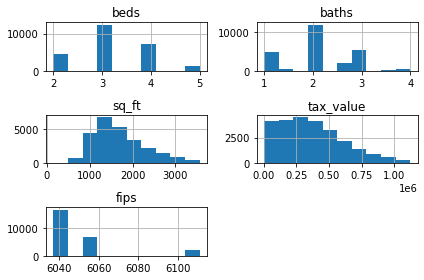

In [4]:
# list unscaled columns for visualization
unscaled_cols = ['beds', 'baths', 'sq_ft', 'tax_value', 'fips']
# visualize distributions of individual features
train[unscaled_cols].hist()
plt.tight_layout()

- `beds`, `sq_ft`, and `tax_value` have mostly normal distributions.
- There is some semblance of normality for `baths` but not really.

In [5]:
# view value counts for fips
train.fips.value_counts()

6037    16649
6059     6761
6111     2140
Name: fips, dtype: int64

<AxesSubplot:xlabel='fips', ylabel='count'>

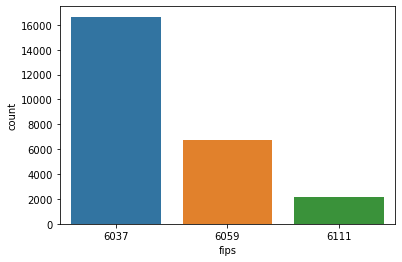

In [6]:
# view distribution for just fips
sns.countplot(x='fips', data=train)

There are 3 FIPS codes in this dataset:
- 6037
- 6059
- 6111

Since the email I received mentioned wanting to know where the properties are located, I will take a moment to research the location codes above.

...

According to https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697, the codes represent the following locations:
- 6037: Los Angeles, CA
- 6059: Orange, CA
- 6111: Ventura, CA

With this information, I can go back and add a column to show where each property is located. For now, I will continue with my data exploration and attempt to answer my initial questions.

### Question 1: Does a home's location affect how much it costs?

In [7]:
# add column of location names
train['fips_loc'] = train.fips.replace({6037:'Los Angeles, CA',
                   6059:'Orange, CA',
                   6111:'Ventura, CA'})
train.head()

,beds,baths,sq_ft,tax_value,fips,fips_loc,beds_scaled,baths_scaled,sq_ft_scaled
17227,2.0,1.0,877.0,148732.0,6037,"Los Angeles, CA",-1.536937,-1.517808,-1.348418
36170,3.0,2.0,1386.0,319465.0,6059,"Orange, CA",-0.268813,-0.139870,-0.518473
16538,4.0,2.5,2064.0,810703.0,6059,"Orange, CA",0.999311,0.549099,0.587033
29765,3.0,2.0,1323.0,393000.0,6037,"Los Angeles, CA",-0.268813,-0.139870,-0.621197
22836,4.0,3.0,2605.0,202872.0,6037,"Los Angeles, CA",0.999311,1.238067,1.469155


In [8]:
def label_fips(zillow):
    zillow['fips'] = zillow.fips.astype(int)
    zillow['fips_loc'] = zillow.fips.replace({6037:'Los Angeles, CA',
                       6059:'Orange, CA',
                       6111:'Ventura, CA'})
    return zillow

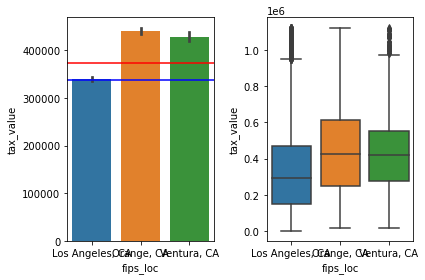

In [9]:
# plot tax_value distributions by location
plt.subplot(121)
sns.barplot(data=train, x='fips_loc', y='tax_value')
plt.axhline(y=train.tax_value.mean(), color='r')
plt.axhline(y=train.tax_value.median(), color='b')
plt.subplot(122)
sns.boxplot(data=train, x='fips_loc', y='tax_value')
plt.tight_layout()

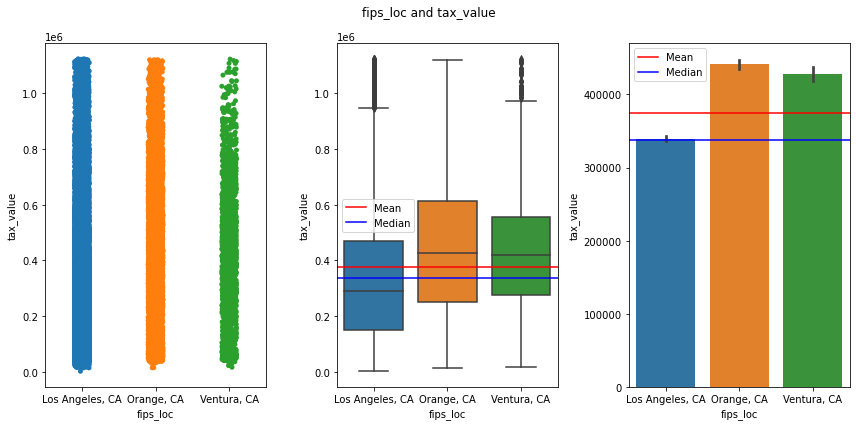

In [10]:
# make function to plot cat/cont variables
def plot_categorical_and_continuous_vars(df, cat_cols, cont_cols):
    '''
    This function takes in a dataframe and the names of categorical and continuous
    columns. It returns a stripplot, boxplot, and barplot of the inputted features.
    '''
    for cat_col, cont_col in list(itertools.product(cat_cols, cont_cols)):
        plt.figure(figsize=(12,6))
        plt.subplot(1, 3, 1)
        sns.stripplot(x=cat_col, y=cont_col, data=df)
        plt.subplot(1, 3, 2)
        sns.boxplot(x=cat_col, y=cont_col, data=df)
        plt.axhline(y=train[cont_col].mean(), color='r', label='Mean')
        plt.axhline(y=train[cont_col].median(), color='b', label='Median')
        plt.legend()
        plt.subplot(1, 3, 3)
        sns.barplot(x=cat_col, y=cont_col, data=df)
        plt.axhline(y=train[cont_col].mean(), color='r', label='Mean')
        plt.axhline(y=train[cont_col].median(), color='b', label='Median')
        plt.suptitle(f'{cat_col} and {cont_col}')
        plt.legend()
        plt.tight_layout()
    return plt.show();
# run function to view fips_loc/tax_value
plot_categorical_and_continuous_vars(train, ['fips_loc'], ['tax_value'])

In [11]:
# view select tax_value summary stats by location
clearly_describe(train.groupby(by='fips_loc')).tax_value.rename(columns={'50%':'median'})[['count', 'mean', 'min', 'median', 'max']]

,count,mean,min,median,max
fips_loc,,,,,
"Los Angeles, CA",16649,339637,1000,290324,1.12355e+06
"Orange, CA",6761,441422,13524,426503,1.12053e+06
"Ventura, CA",2140,428344,15433,419958,1.12241e+06


**Takeaways:**
- Los Angeles, CA has the lowest mean and median tax values
- Orange, CA has the highest mean and median tax values
- Most homes are located in Los Angeles, CA
- Fewest homes are located in Ventura, CA
- The cheapest home is located in Los Angeles, CA
- The most expensive home is also located in Los Angeles, CA

There does seem to be some variance in tax_value depending on where the home is located. To be sure there is a relationship, I will perform a statistical test. Before choosing a test, I will see what my options are based on which assumptions the data meets.

In [12]:
# view variances of samples
train.groupby(by='fips_loc').tax_value.var()

fips_loc
Los Angeles, CA    5.678131e+10
Orange, CA         6.286669e+10
Ventura, CA        4.968188e+10
Name: tax_value, dtype: float64

fips_loc
Los Angeles, CA    AxesSubplot(0.125,0.125;0.775x0.755)
Orange, CA         AxesSubplot(0.125,0.125;0.775x0.755)
Ventura, CA        AxesSubplot(0.125,0.125;0.775x0.755)
Name: tax_value, dtype: object

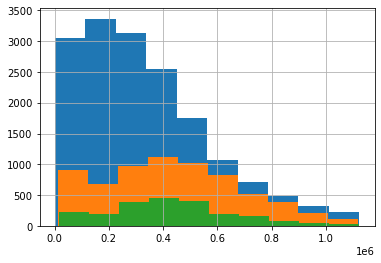

In [13]:
# view distributions of samples
train.groupby(by='fips_loc').tax_value.hist()

My samples are independent of one another.

The distributions are normal enough for the large samples I have.

The variances, however, vary greatly between samples so that rules out the ANOVA test. Instead, I will perform three independent 2-sample T-tests to compare each sample against the population not included in that sample.

In [14]:
# separate each location's tax_value observations into individual series
la_value = train[train.fips_loc == 'Los Angeles, CA'].tax_value
or_value = train[train.fips_loc == 'Orange, CA'].tax_value
ve_value = train[train.fips_loc == 'Ventura, CA'].tax_value

**Test 1: Is there a difference between homes in Los Angeles and homes not in Los Angeles?**

$H_{0}$: There is no difference in tax value between homes in Los Angeles and homes not in Los Angeles.

$H_{a}$: There is a significant difference in tax value between homes in Los Angeles and homes not in Los Angeles.

In [15]:
# set alpha
alpha = 0.05
# isolate tax values of properties not in los angeles
non_la_value = train[train.fips_loc != 'Los Angeles, CA'].tax_value
# run t-test
t, p = stats.ttest_ind(la_value, non_la_value, equal_var=False)
# print result
if p < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')
# output t-statistic and p-value
t, p

Reject the null hypothesis


(-31.007191968235666, 1.2367728611954127e-205)

**Test 2: Is there a difference between homes in Orange and homes not in Orange?**

$H_{0}$: There is no difference in tax value between homes in Orange and homes not in Orange.

$H_{a}$: There is a significant difference in tax value between homes in Orange and homes not in Orange.

In [16]:
# is there a difference between orange and non-orange homes
# null = There is no difference between homes in Orange and homes not in Orange.
# alt = There is a difference between homes in Orange and homes not in Orange.
# isolate tax values of properties not in orange
non_or_value = train[train.fips_loc != 'Orange, CA'].tax_value
# run t-test
t, p = stats.ttest_ind(or_value, non_or_value, equal_var=False)
# print result
if p < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')
# output t-statistic and p-value
t, p

Reject the null hypothesis


(26.12060430322319, 3.918154422883161e-146)

**Test 3: Is there a difference between homes in Ventura and homes not in Ventura?**

$H_{0}$: There is no difference in tax value between homes in Ventura and homes not in Ventura.

$H_{a}$: There is a significant difference in tax value between homes in Ventura and homes not in Ventura.

In [17]:
# is there a difference between homes located in ventura and homes not located in ventura?
# null = There is no difference between homes in Ventura and homes not in Ventura.
# alt = There is a difference between homes in Ventura and homes not in Ventura.
# isolate tax values of properties not in ventura
non_ve_value = train[train.fips_loc != 'Ventura, CA'].tax_value
# run t-test
t, p = stats.ttest_ind(ve_value, non_ve_value, equal_var=False)
# print result
if p < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')
# output t-statistic and p-value
t, p

Reject the null hypothesis


(11.675010059966073, 9.610286804156213e-31)

In each of the three t-tests I ran, the results provided evidence to support the rejection of the null hypotheses that there is not a significant difference in tax value between homes in a county versus homes not in that county.

That is to say, **there is a difference in tax assessed property value depending on where the home is located.**

### Question 2: Is there a relationship between number of bedrooms and number of bathrooms?

In [18]:
# continuous vs continuous
pd.crosstab(train.beds, train.baths).corr()

baths,1.0,1.5,2.0,2.5,3.0,3.5,4.0
baths,,,,,,,
1.0,1.000000,0.678814,0.340928,-0.061781,-0.526575,-0.723408,-0.913997
1.5,0.678814,1.000000,0.902660,0.599194,0.041896,-0.300456,-0.473486
2.0,0.340928,0.902660,1.000000,0.883204,0.461034,0.131083,-0.051204
2.5,-0.061781,0.599194,0.883204,1.000000,0.823352,0.580715,0.401870
3.0,-0.526575,0.041896,0.461034,0.823352,1.000000,0.940132,0.820735
3.5,-0.723408,-0.300456,0.131083,0.580715,0.940132,1.000000,0.938934
4.0,-0.913997,-0.473486,-0.051204,0.401870,0.820735,0.938934,1.000000


<AxesSubplot:xlabel='baths', ylabel='baths'>

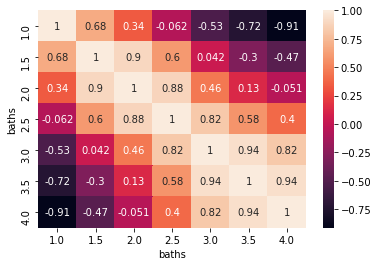

In [19]:
sns.heatmap(pd.crosstab(train.beds, train.baths).corr(), annot=True)

<AxesSubplot:xlabel='beds', ylabel='baths'>

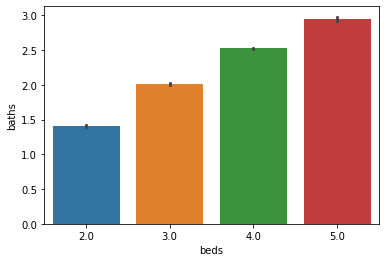

In [20]:
sns.barplot(data=train, x='beds', y='baths')

From this visualization, I can clearly see that on average, the more bedrooms a home has, the more bathrooms it will have.

**Yes, there is a relationship between number of bedrooms and number of bathrooms.**

### Question 3: Do bigger homes have more bathrooms?

<AxesSubplot:xlabel='baths', ylabel='sq_ft'>

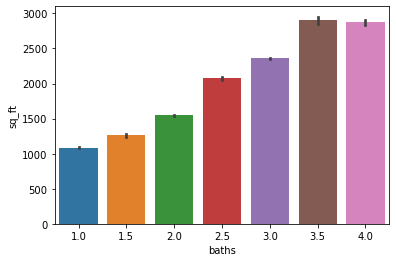

In [21]:
# sq_ft vs baths
sns.barplot(data=train, y='sq_ft', x='baths')

**Yes, bigger homes tend to have more bathrooms.**

### Question 4: What drives tax_value? (Which features are most strongly correlated with tax value?)

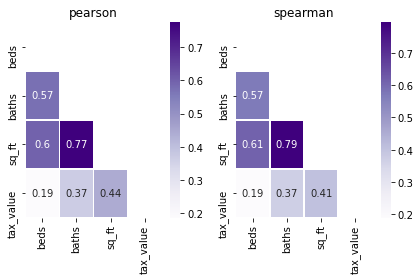

In [22]:
from scipy.stats import pearsonr, spearmanr
plt.subplot(121)
zillow_corr = train[out_cols].corr()
sns.heatmap(zillow_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(zillow_corr))
plt.title('pearson')
plt.subplot(122)
zillow_spearman = train[out_cols].corr(method='spearman')
sns.heatmap(zillow_spearman, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(zillow_spearman))
plt.title('spearman')
plt.tight_layout()
plt.show()

- Looks like `sq_ft` is the most correlated with `tax_value` 
- The strongest relationship in this heatmap is that between `baths` and `sq_ft`

I want to get a better feel for which features are most strongly driving `tax_value` so I will use Select K-Best and Recursive Feature Elimination to rank the features.

In [23]:
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression

# split data into x and y
# predictors
x = train[['beds_scaled', 'baths_scaled', 'sq_ft_scaled', 'fips']]
# target
y = train.tax_value
# create f_selector object
f_selector = SelectKBest(f_regression, 3)
# fit object to data
f_selector.fit(x, y)
# mask of features list
f_mask = f_selector.get_support()
# list True features
f_feature = x.iloc[:,f_mask].columns.tolist()
print(f_feature)

# create linear regression object
lm = LinearRegression()
# create rfe object
rfe = RFE(lm, 1)
# fit object to data
rfe.fit(x, y)
# mask
f_mask = rfe.support_
# list features
rfe_feature = x.iloc[:,f_mask].columns.tolist()
print(rfe_feature)

['beds_scaled', 'baths_scaled', 'sq_ft_scaled']
['sq_ft_scaled']


In [24]:
rfe.ranking_
rfe_ranks = pd.DataFrame({'Feature':x.columns.tolist(), 'Rank':rfe.ranking_})
rfe_ranks.sort_values('Rank')

,Feature,Rank
2,sq_ft_scaled,1
0,beds_scaled,2
1,baths_scaled,3
3,fips,4


So according to RFE, the features in order of importance are: `sq_ft`, `beds`, `baths`, then `fips`.

However, according to Select K-Best, `baths` is more important than `beds`.

Using either method, **`sq_ft` is the biggest driver of `tax_value`.**

Just to be sure, I'll run a correlation test between `tax_value` and `sq_ft`

$H_{0}$: There is no linear correlation between `sq_ft` and `tax_value`

$H_{a}$: There is a significant linear correlation between `sq_ft` and `tax_value`

array([[<AxesSubplot:title={'center':'sq_ft'}>,
        <AxesSubplot:title={'center':'tax_value'}>]], dtype=object)

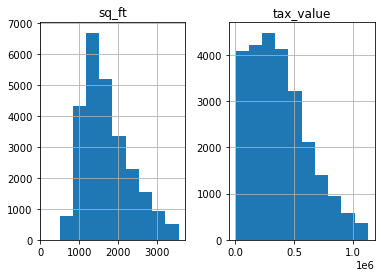

In [25]:
# view distributions of variables
train[['sq_ft', 'tax_value']].hist()

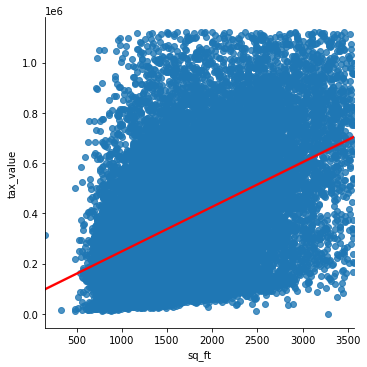

In [26]:
# view lmplot
sns.lmplot(data=train, x='sq_ft', y='tax_value', line_kws={'color':'red'})

In [27]:
# calculate corr, p-value
corr, p = stats.pearsonr(train.sq_ft, train.tax_value)
corr, p

(0.4439850137758975, 0.0)

There is evidence to support rejecting the null hypothesis.

The correlation test confirms that there is a linear relationship between `sq_ft` and `tax_value`.

## Data Exploration Summary

### Initial Questions
1. Does a home's location affect how much it costs?
2. Is there a relationship between number of bedrooms and number of bathrooms?
3. Do bigger homes have more bathrooms?
4. What drives tax_value? (Which features are most strongly correlated with tax value?)

### Key Findings
- There is a linear correlation between `sq_ft` and `tax_value`
- There is a significant relationship between `baths` and `sq_ft`
- There is a difference in mean home value depending on where the home is located.
- There is a relationship between `beds` and `baths`

### Takeaways
- At this point, `sq_ft` appears to be the strongest driver of `tax_value`
- On average, more bedrooms means more bathrooms
- Bigger houses have more bathrooms
- Although `fips` does seem to have an effect on `tax_value`, it does not appear to be significant enough to include in the modeling stage at this time.

### Actions
- I will use `sq_ft`, `beds`, and `baths` to create my models.